# Lesson 10 - Sentiment Analysis

This assignment requires that you build a sentiment analysis classifier for a series of tweets.
The data consists of a file "twitter_data.csv". The file contains 16,000 tweets with their respective score. The attributes are the sentences, and the score is either 4 (for positive) or 0 (for negative).

Assignment Instructions
1. Complete all questions below.
2. Comment on the applicability of the model on future tweets.  

In [1]:
#Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from scipy.sparse import coo_matrix
from wordcloud import WordCloud, STOPWORDS 

In [2]:
#Read files
url = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/twitter_data.csv"
df = pd.read_csv(url, sep=",")
df.columns = ["sentiment_label","tweet_text"]
    
print(df.head())

   sentiment_label                                         tweet_text
0                4  @elephantbird Hey dear, Happy Friday to You  A...
1                4  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...


In [3]:
# We'll change that to '1' or '0' to indicate positive or negative sentiment.
df.sentiment_label=df.sentiment_label.replace(4,1)

In [4]:
# Create a function to clean data
def preprocess(text, list_of_steps):
    lmtzr = WordNetLemmatizer()
    for step in list_of_steps:
        if step == 'remove_non_ascii':
            text = ''.join([x for x in text if ord(x) < 128])
        elif step == 'lowercase':
            text = text.lower()
        elif step == 'remove_punctuation':
            punct_exclude = set(string.punctuation)
            text = ''.join(char for char in text if char not in punct_exclude)
        elif step == 'remove_numbers':
            text = re.sub("\d+", "", text)
        elif step == 'strip_whitespace':
            text = ' '.join(text.split())
        elif step == 'remove_stopwords':
            stops = stopwords.words('english')
            word_list = text.split(' ')
            text_words = [word for word in word_list if word not in stops]
            text = ' '.join(text_words)
        elif step == 'stem_words':
            lmtzr = WordNetLemmatizer()
            word_list = text.split(' ')
            stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
            text = ' '.join(stemmed_words)
    return text

step_list = ['remove_non_ascii', 'lowercase', 'remove_punctuation', 'remove_numbers',
            'strip_whitespace', 'remove_stopwords', 'stem_words']
steps = ['lowercase', 'remove_punctuation', 'remove_numbers', 'strip_whitespace','remove_stopwords']

df['clean_tweet'] = df['tweet_text'].map(lambda s: preprocess(s, steps))

In [5]:
#create positive and negative data set
positive = df['clean_tweet'][df['sentiment_label'] ==1]
negative = df['clean_tweet'][df['sentiment_label'] ==0]

In [6]:
# Create a document storage matrix
def split_words (df):
    doc = {}
    for ix, row in enumerate(df):
    # Store the sentiment
        doc[ix] = row.split(' ')
    return doc
pos_doc = split_words(positive)

In [7]:
# We want to keep track of how many unique words there are:
def word_string (doc):
    
    vocab = []
    for word_list in doc.values():
        for x in word_list:
            vocab.append(x)
    vocab_str =' '.join(str(x) for x in vocab)
    return vocab_str
vocab_str_pos = word_string(pos_doc)

In [8]:
#plot word_cloud
def word_cloud(text, title):
    wc = WordCloud(background_color="white", repeat=False).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wc) 
    plt.axis('off')
    plt.title(title);

Q1: Generate word cloud for positive sentiment.

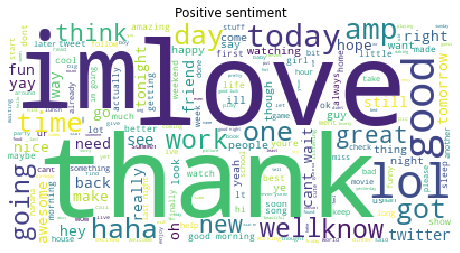

In [9]:
word_cloud(vocab_str_pos, 'Positive sentiment')

Q2: Generate word cloud for negative sentiment.

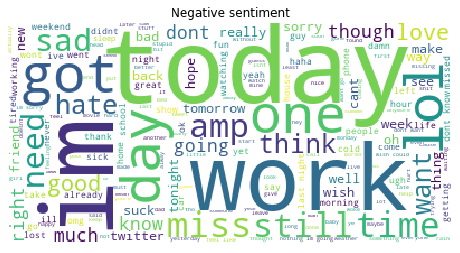

In [10]:
neg_doc = split_words(negative)
vocab_str_neg = word_string(neg_doc)
word_cloud(vocab_str_neg, 'Negative sentiment')

Before builidng the model, let's take a look at the data in a matrix.

In [11]:
tweet_df = df.copy()
tweet_data = tweet_df.values.tolist()

In [12]:
# Create a document storage matrix
clean_texts = tweet_df['clean_tweet']
docs = {}
labels = []
for ix, row in enumerate(clean_texts):
    # Store the sentiment
    labels = tweet_data[ix][0]
    docs[ix] = row.split(' ')

# We want to keep track of how many unique words there are:
num_nonzero = 0
vocab = set()

for word_list in docs.values():
    unique_terms = set(word_list)    # all unique terms of this tweet
    vocab.update(unique_terms)       # set union: add unique terms of this tweet
    num_nonzero += len(unique_terms) # add count of unique terms in this tweet

doc_key_list = list(docs.keys())

doc_key_list = np.array(doc_key_list)
vocab = np.array(list(vocab))
vocab_sorter = np.argsort(vocab)

# Initialize our sparse matrix:
num_docs = len(doc_key_list)
vocab_size = len(vocab)
# A COO matrix is just a tuple of data, row indices, and column indices. Everything else is assumed to be zero.
data = np.empty(num_nonzero, dtype=np.intc)     # all non-zero
rows = np.empty(num_nonzero, dtype=np.intc)     # row index
cols = np.empty(num_nonzero, dtype=np.intc)     # column index

ix = 0
# go through all documents with their terms
print('Computing full term-document matrix (sparse), please wait!')
for doc_key, terms in docs.items():
    # find indices to insert-into such that, if the corresponding elements were
    # inserted before the indices, the order would be preserved
    term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter=vocab_sorter)]

    # count the unique terms of the document and get their vocabulary indices
    uniq_indices, counts = np.unique(term_indices, return_counts=True)
    n_vals = len(uniq_indices)  # = number of unique terms
    ix_end = ix + n_vals # Add count to index.

    data[ix:ix_end] = counts                  # save the counts (term frequencies)
    cols[ix:ix_end] = uniq_indices            # save the column index: index in 
    doc_ix = np.where(doc_key_list == doc_key)   # get the document index for the document name
    rows[ix:ix_end] = np.repeat(doc_ix, n_vals)  # save it as repeated value

    ix = ix_end  # resume with next document -> will add future data on the end.
print('Done!')

Computing full term-document matrix (sparse), please wait!
Done!


In [13]:
# Create the sparse matrix!
doc_term_mat = coo_matrix((data, (rows, cols)), shape=(num_docs, vocab_size), dtype=np.intc)

#### Trimming the Doc-term matrix

We saw above that we are including terms like 'aaaaa' and 'aaaa', which probably occur very few times. These terms generally occur with unstructured text fields because we allow users to input whatever they feel like and that includes typos.  But be aware that they can also be artifacts of our cleaning process (unintentionally and intentionally).


In [14]:
# Look at how many words are above a specific cutoff
word_counts = doc_term_mat.sum(axis=0)
cutoff = 15
word_count_list = word_counts.tolist()[0]
# Find which column indices are above cutoff
col_cutoff_ix = [ix for ix, count in enumerate(word_count_list) if count > cutoff]

print('Number of words w/counts above {} : {}'.format(cutoff, len(col_cutoff_ix)))

Number of words w/counts above 15 : 6095


Using the cut-off equals to 15, there're 6228 terms occur more than 15 times.

#### Computing term frequency
Scikit-Learn has a built in TF-IDF transformation function that we will use to calculate this and prepare the dataset.

In [15]:
# Declare the TFIDF vectorizer.
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')

# Fit the vectorizer over the dataset
clean_texts = df['clean_tweet']
tf_idf_tweets = vectorizer.fit_transform(clean_texts)

Q3: Split data into 70% for training and 30% for testing.

In [16]:
# Generate 40,000 random row indices
from sklearn.model_selection import train_test_split

y_targets = np.array([y[0] for y in tweet_data])

X_train, X_test, y_train, y_test = train_test_split(tf_idf_tweets,
                                                    y_targets,
                                                    test_size=0.3,
                                                    random_state=42)
print('Done! Test set to be 30% of the data.')

Done! Test set to be 30% of the data.


Q4: Build a classifier that classifies the sentiment of a sentence.

In [17]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB().fit(X_train, y_train)

I used BernoulliNB naive bayes classifier, which is suitable for binary features. 

Q5: What is the accuracy of your model when applied to testing data?

In [18]:
train_probs = clf.predict_proba(X_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = clf.predict_proba(X_test)
test_results = np.argmax(test_probs, axis=1)

# Compute accuracies
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy: %.2f'%(train_acc))
print('Test accuracy: %.2f'%(test_acc))

Train accuracy: 0.87
Test accuracy: 0.75


Accuracy for test data is 0.75, which is lower than trainning accuracy. It suggests that the model overfits that doesn't do a good job on generalization.

In [19]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Remember:
# Precision is the proportion of correct predictions among all predicted
# Recall (sensitivity) is the proportion of correct predictions among all true actual examples
# F1 is the harmonic average of precision and recall
# Support is count of actual cases of specific class
# Here, each of the following is a pair of numbers, the first is for class 1 ('1') and second for class 0 ('0')
precision, recall, f1, support = precision_recall_fscore_support(y_test, test_results)

# Get the parts of the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, test_results).ravel()

# Print results
print(confusion_matrix(y_test, test_results))
print('='*35)
print('             Class 1   -   Class 0')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

[[18648  5396]
 [ 6587 17369]]
             Class 1   -   Class 0
Precision: [0.73897365 0.76296947]
Recall   : [0.77557811 0.72503757]
F1       : [0.75683354 0.74352004]
Support  : [24044 23956]


Precision, recall and Fscore of the model for positive and negative tweets are reported. They all above 0.7, indicating that model is pretty good.

Q6: What conclusions can you draw from the model?

As I discussed above, the testing accuracy is lower than training accuracy, implying that the model is overfitting. To improve the model performances, there're some hyperparameters need to be tuned, such as the cutoff value (how frequent of a word can be considered useful when determining sentiment). 



Q7: Is it better to have a model per source?

Question skipped as per discussion in L10 Code talk.

Comment on the applicability of the model on future tweets.

The model is built using Bernoulli Naive Bayes model. However, the model is slightly overfitting with train accuracy higher than test accuracy, while precision, recall and F1 indicate that model is not bad.To improve the tweet analysis, we can try linear regression with some regularization. 
